In [1]:
!pip install rdkit

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 36.4/36.4 MB 48.6 MB/s eta 0:00:00


In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory
import sentence_transformers as st
from sklearn.neighbors import KNeighborsRegressor
import pickle
import os
import joblib
import shutil
from pathlib import Path
from tqdm.auto import tqdm

import os
for dirname, _, filenames in os.walk('../input'):
    for filename in filenames[:4]:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

2026-01-19 18:11:21.600076: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1768846281.774161      24 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1768846281.823111      24 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1768846282.234638      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768846282.234676      24 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1768846282.234679      24 computation_placer.cc:177] computation placer alr

../input/openadmet2025-pretrain-rncloss/__results__.html
../input/openadmet2025-pretrain-rncloss/__huggingface_repos__.json
../input/openadmet2025-pretrain-rncloss/__notebook__.ipynb
../input/openadmet2025-pretrain-rncloss/mixer_wrapper.py
../input/openadmet2025-pretrain-rncloss/openadmet-v1-model/config.json
../input/openadmet2025-pretrain-rncloss/openadmet-v1-model/merges.txt
../input/openadmet2025-pretrain-rncloss/openadmet-v1-model/README.md
../input/openadmet2025-pretrain-rncloss/openadmet-v1-model/tokenizer.json
../input/openadmet2025-pretrain-rncloss/openadmet-v1-model/1_Pooling/config.json
../input/openadmet2025-pretrain-rncloss/openadmet-v1-model/3_MixerWrapper/config.json
../input/openadmet2025-pretrain-rncloss/openadmet-v1-model/3_MixerWrapper/model.safetensors
../input/openadmet2025-pretrain-rncloss/model_saves/runs/Jan19_08-46-02_538c81cca95f/events.out.tfevents.1768812368.538c81cca95f.24.0
../input/openadmet2025-pretrain-rncloss/model_saves/checkpoint-31280/config.json
..

In [3]:
OUTPUTDIR = Path("../working")
OUTPUTDIR.mkdir(exist_ok=True)

In [4]:
import os
import random
import numpy as np
import torch


def set_seed(seed: int = 42) -> None:
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ["PYTHONHASHSEED"] = str(seed)
    print(f"Random seed set as {seed}")

RANDOM_SEED = 3407  # 42  # 3407
set_seed(RANDOM_SEED)

Random seed set as 3407


## Data preparation

In [5]:
import kagglehub

openadmet_data_split_path = kagglehub.notebook_output_download('latticetower/openadmet2026-data-split')
openadmet_pretrain_path = kagglehub.notebook_output_download('latticetower/openadmet2026-pretrain-rncloss')
#train_df = pd.read_csv(Path(neurips_open_polymer_prediction_2025_path) / "train.csv")
# train_df['id'] = train_df['id'].apply(lambda x: f"{x}")
merged_df = pd.read_csv(Path(openadmet_data_split_path) / "train_folds.csv")


#fold_df['id'] = fold_df['id'].apply(lambda x: f"{x}")
#fold_columns = [
#    'id',
#    'test_fold',
#    'fold_name',
# ]
additional_smiles_columns = [
    col for col in merged_df.columns if col.startswith('AUG_SMILES')
]


train_df = merged_df.loc[merged_df.fold_name.isin(['train'#, 'test', 'val'
                                                  ])].reset_index(drop=True)
val_df = merged_df.loc[merged_df.fold_name == 'val'].reset_index(drop=True)
test_df = merged_df.loc[merged_df.fold_name == 'test'].reset_index(drop=True)

In [6]:
# train_df
print(train_df.shape, val_df.shape, test_df.shape)
merged_df.head()

(4267, 27) (529, 27) (529, 27)


,Molecule Name,SMILES,LogD,KSOL,HLM CLint,MLM CLint,Caco-2 Permeability Papp A>B,Caco-2 Permeability Efflux,MPPB,MBPB,...,AUG_SMILES_2,AUG_SMILES_3,AUG_SMILES_4,AUG_SMILES_5,AUG_SMILES_6,AUG_SMILES_7,AUG_SMILES_8,AUG_SMILES_9,AUG_SMILES_10,num_candidates
0,E-0001321,CN1CCCC1COc1ccc(-c2nc3cc(-c4ccc5[nH]c(-c6ccc(O...,NaN,NaN,56.4,182.3,NaN,NaN,NaN,NaN,...,C1CN(C)C(C1)COc1ccc(cc1)-c1nc2cc(-c3ccc4c(c3)n...,CN1C(COc2ccc(-c3nc4c(ccc(-c5ccc6[nH]c(nc6c5)-c...,Oc1ccc(-c2[nH]c3c(cc(cc3)-c3ccc4c(c3)nc([nH]4)...,Oc1ccc(-c2[nH]c3c(n2)cc(cc3)-c2cc3c([nH]c(n3)-...,[nH]1c2ccc(cc2nc1-c1ccc(cc1)OCC1N(CCC1)C)-c1cc...,c1(-c2ccc(O)cc2)[nH]c2c(n1)cc(cc2)-c1ccc2c(nc(...,c1(-c2ccc(cc2)OCC2N(CCC2)C)nc2c([nH]1)ccc(c2)-...,c1(-c2ccc3c(nc(-c4ccc(OCC5N(C)CCC5)cc4)[nH]3)c...,c1(cc2nc(-c3ccc(cc3)O)[nH]c2cc1)-c1cc2c(cc1)[n...,10.0
1,E-0001780,COc1ccc2c(c1)c1cc3cnccc3c(C)c1n2C,NaN,NaN,160.4,1351.1,NaN,NaN,NaN,NaN,...,COc1ccc2n(C)c3c(C)c4c(cc3c2c1)cncc4,COc1ccc2n(c3c(c2c1)cc1cnccc1c3C)C,Cc1c2c(cc3c4cc(OC)ccc4n(C)c31)cncc2,Cn1c2c(C)c3c(cc2c2cc(OC)ccc12)cncc3,O(C)c1ccc2n(c3c(c4ccncc4cc3c2c1)C)C,O(c1cc2c3cc4c(ccnc4)c(C)c3n(C)c2cc1)C,c12c(C)c3ccncc3cc2c2c(n1C)ccc(c2)OC,c12c(c(C)c3n(C)c4ccc(OC)cc4c3c1)ccnc2,c12c(ccc(c2)OC)n(c2c(C)c3c(cncc3)cc12)C,10.0
2,E-0001827,Cc1c2ccncc2cc2c3cc(OCCCN4CCN(C)CC4)ccc3n(C)c12,NaN,NaN,NaN,193.5,NaN,NaN,NaN,NaN,...,C1CN(C)CCN1CCCOc1cc2c(cc1)n(C)c1c2cc2c(c1C)ccnc2,C1CN(CCN1C)CCCOc1ccc2n(c3c(c4ccncc4cc3c2c1)C)C,CN1CCN(CC1)CCCOc1ccc2n(c3c(c4ccncc4cc3c2c1)C)C,N1(CCCOc2ccc3c(c4c(n3C)c(c3ccncc3c4)C)c2)CCN(C...,N1(CCN(CCCOc2cc3c(cc2)n(c2c3cc3cnccc3c2C)C)CC1)C,O(c1cc2c(n(C)c3c2cc2c(ccnc2)c3C)cc1)CCCN1CCN(C...,O(c1cc2c(n(c3c(C)c4c(cncc4)cc23)C)cc1)CCCN1CCN...,O(c1cc2c(n(c3c2cc2cnccc2c3C)C)cc1)CCCN1CCN(C)CC1,c12c(c(C)c3c(c1)cncc3)n(C)c1ccc(cc21)OCCCN1CCN...,10.0
3,E-0002019,CN(C)CCCOc1ccc(-c2nc3cc(NC(=O)c4ccc5[nH]c(-c6c...,NaN,NaN,9.5,NaN,NaN,NaN,NaN,NaN,...,C(CCOc1ccc(-c2nc3cc(ccc3[nH]2)NC(c2cc3nc([nH]c...,C(c1cc2nc([nH]c2cc1)-c1ccc(cc1)OCCCN(C)C)(Nc1c...,CN(C)CCCOc1ccc(cc1)-c1nc2c(ccc(c2)C(Nc2cc3nc(-...,O(c1ccc(cc1)-c1nc2c([nH]1)ccc(c2)C(Nc1ccc2[nH]...,[nH]1c(nc2cc(C(Nc3cc4nc([nH]c4cc3)-c3ccc(cc3)O...,c1(-c2[nH]c3c(n2)cc(C(Nc2cc4nc(-c5ccc(OCCCN(C)...,c1(-c2nc3cc(NC(c4ccc5c(c4)nc(-c4ccc(cc4)OCCCN(...,c1(ccc(-c2nc3c([nH]2)ccc(C(=O)Nc2cc4c(cc2)[nH]...,c1(ccc(cc1)-c1nc2cc(ccc2[nH]1)NC(c1cc2nc(-c3cc...,10.0
4,E-0002036,CN(C)CCCOc1ccc2nc(-c3ccc(-c4nc5ccc(OCCCN(C)C)c...,NaN,NaN,NaN,162.0,NaN,NaN,NaN,NaN,...,C(COc1cc2c(cc1)nc(-c1ccc(-c3[nH]c4c(n3)ccc(c4)...,C(COc1ccc2c([nH]c(n2)-c2cc(c(cc2)-c2nc3ccc(cc3...,C(N(C)C)CCOc1cc2[nH]c(-c3cc(F)c(cc3)-c3nc4c(cc...,C(Oc1cc2[nH]c(-c3ccc(-c4nc5c(cc(cc5)OCCCN(C)C)...,C(Oc1cc2c(cc1)nc(-c1c(F)cc(cc1)-c1[nH]c3c(n1)c...,CN(CCCOc1cc2c(nc([nH]2)-c2cc(F)c(-c3[nH]c4c(cc...,N(CCCOc1cc2c(cc1)nc(-c1ccc(c(c1)F)-c1nc3ccc(OC...,c1(-c2[nH]c3cc(OCCCN(C)C)ccc3n2)ccc(-c2[nH]c3c...,c1(OCCCN(C)C)cc2[nH]c(-c3cc(F)c(-c4nc5c(cc(OCC...,10.0


In [7]:
TARGET_COLUMNS = [
    'LogD', 
    'KSOL', 
    'HLM CLint', 'MLM CLint',
    'Caco-2 Permeability Papp A>B', 'Caco-2 Permeability Efflux', 
    'MPPB',
    'MBPB', 'MGMB'
]

#MODEL_NAME = "DeepChem/ChemBERTa-77M-MLM"

#model = st.SentenceTransformer(MODEL_NAME, model_kwargs=dict(add_pooling_layer=False))
#model.save_pretrained("chemberta_untrained")  # save as is to reuse in inference notebook

MODELDIR = Path(openadmet_pretrain_path) / "openadmet-v1-model"

model = st.SentenceTransformer(
    MODELDIR.as_posix(), 
    model_kwargs=dict(add_pooling_layer=False)
)
# model.save_pretrained("polyBERT")  # save as is to reuse in inference notebook
# shutil.copy(MODELDIR / "mixer_wrapper.py", "polyBERT")
if not Path("openadmet-v1-model").exists():
    shutil.copytree(MODELDIR.as_posix(), "openadmet-v1-model")


## Prepare embeddings

In [8]:
train_embeddings = model.encode(
    train_df.SMILES.values, 
    normalize_embeddings=True
)
val_embeddings = model.encode(
    val_df.SMILES.values, 
    normalize_embeddings=True)
test_embeddings = model.encode(
    test_df.SMILES.values, 
    normalize_embeddings=True)

In [9]:
SAVEDIR = Path("regressors")
SAVEDIR.mkdir(exist_ok=True)

In [10]:
train_embeddings.shape#, train_features.shape

(4267, 384, 9)

In [11]:
USE_FEATURES = False
if len(train_embeddings.shape) == 3 and train_embeddings.shape[-1] == 9:
    train_embeddings5 = np.concatenate([train_embeddings[:, :, i] for i in range(9)], axis=1)
    val_embeddings5 = np.concatenate([val_embeddings[:, :, i] for i in range(9)], axis=1)
    test_embeddings5 = np.concatenate([test_embeddings[:, :, i] for i in range(9)], axis=1)
    
if USE_FEATURES:
    # train_features5 = np.stack([train_features]*5, axis=-1)
    # val_features5 = np.stack([val_features]*5, axis=-1)
    # test_features5 = np.stack([test_features]*5, axis=-1)
    
    # train_x = np.concatenate([train_embeddings, train_features5], axis=1)
    # val_x = np.concatenate([val_embeddings, val_features5], axis=1)
    # test_x = np.concatenate([test_embeddings, test_features5], axis=1)
    train_x = np.concatenate([train_embeddings5, train_features], axis=1)
    val_x = np.concatenate([val_embeddings5, val_features], axis=1)
    test_x = np.concatenate([test_embeddings5, test_features], axis=1)
else:
    train_x = train_embeddings5
    val_x = val_embeddings5
    test_x = test_embeddings5

  0%|          | 0/9 [00:00<?, ?it/s]

0 LogD
column: LogD - 4032 samples
1 KSOL
column: KSOL - 4108 samples


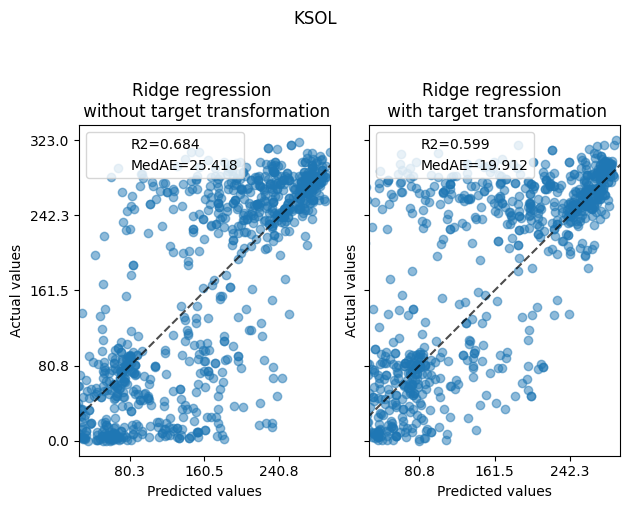

2 HLM CLint
column: HLM CLint - 3012 samples


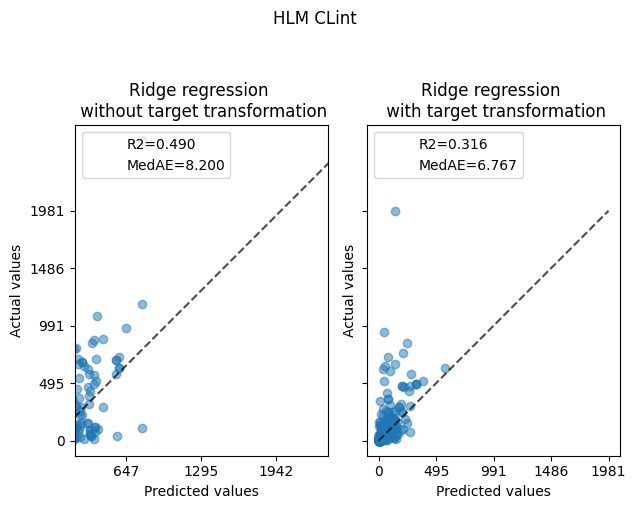

3 MLM CLint
column: MLM CLint - 3623 samples


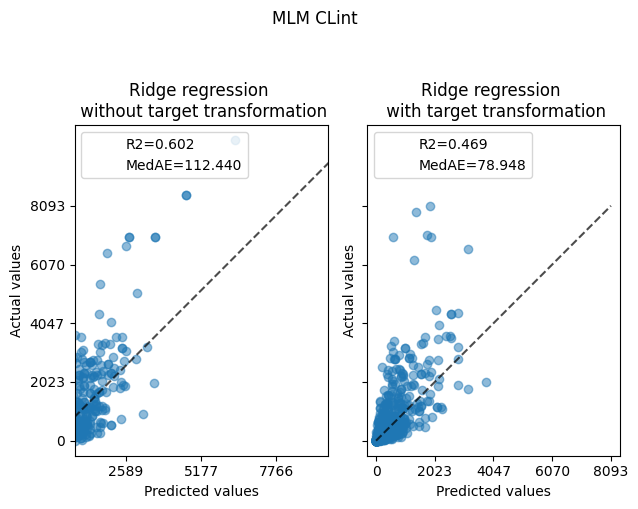

4 Caco-2 Permeability Papp A>B
column: Caco-2 Permeability Papp A>B - 1727 samples


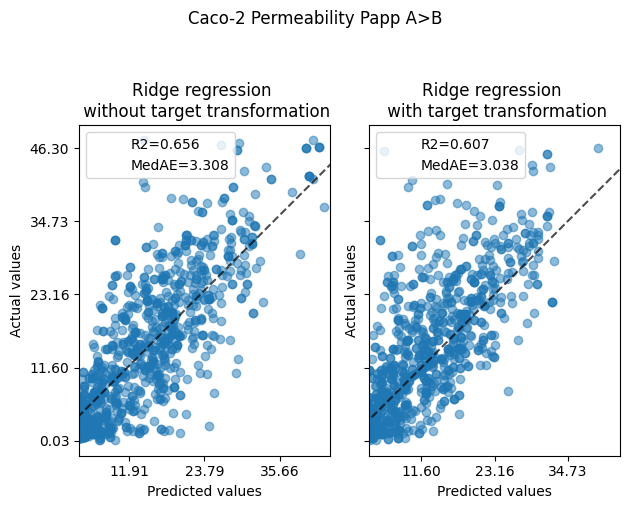

5 Caco-2 Permeability Efflux
column: Caco-2 Permeability Efflux - 1729 samples


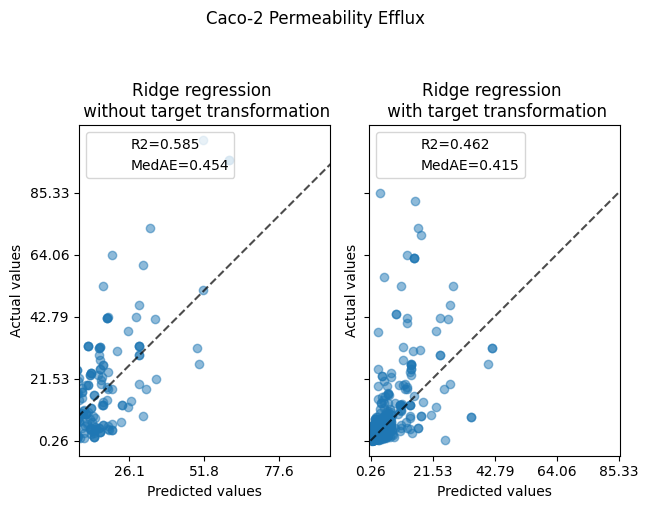

6 MPPB
column: MPPB - 1050 samples


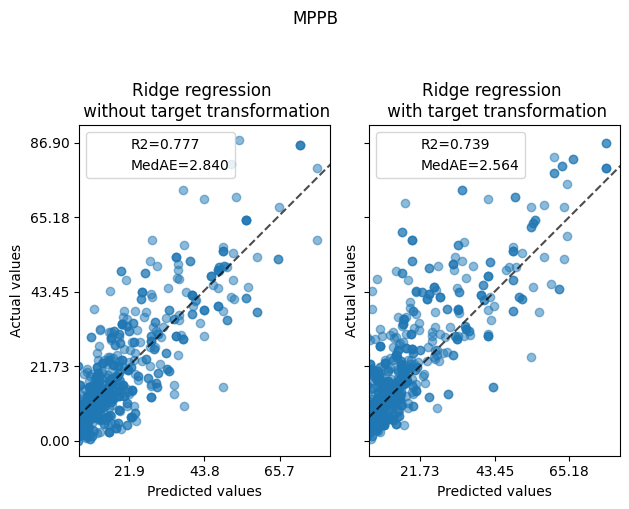

7 MBPB
column: MBPB - 780 samples


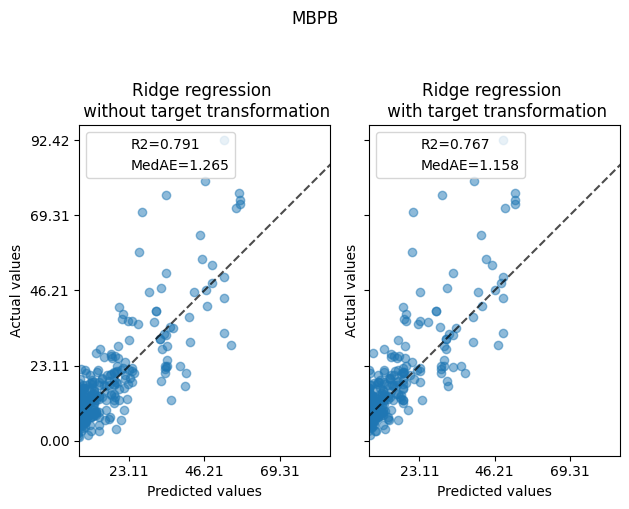

8 MGMB
column: MGMB - 181 samples


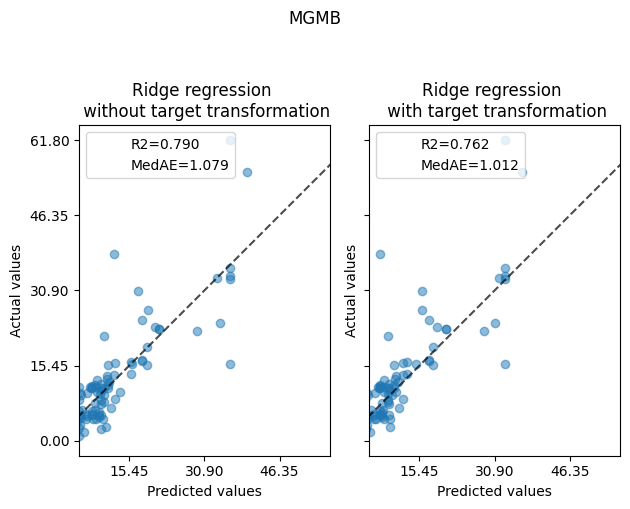

In [12]:
import joblib
from tqdm.auto import tqdm
import sklearn.metrics as sk
from sklearn.preprocessing import QuantileTransformer, StandardScaler
from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.ensemble import BaggingRegressor
import matplotlib.pyplot as plt
# from sklearn.linear_model import RidgeCV
from sklearn.metrics import PredictionErrorDisplay

from sklearn.metrics import median_absolute_error, r2_score


def compute_score(y_true, y_pred):
    return {
        "R2": f"{r2_score(y_true, y_pred):.3f}",
        "MedAE": f"{median_absolute_error(y_true, y_pred):.3f}",
    }
    
def draw_comparison(targets, pred, pred_log, title=''):
    # https://scikit-learn.org/stable/auto_examples/compose/plot_transformed_target.html
    f, (ax0, ax1) = plt.subplots(1, 2, sharey=True)

    PredictionErrorDisplay.from_predictions(
        targets,
        pred,
        kind="actual_vs_predicted",
        ax=ax0,
        scatter_kwargs={"alpha": 0.5},
    )
    PredictionErrorDisplay.from_predictions(
        targets,
        pred_log,
        kind="actual_vs_predicted",
        ax=ax1,
        scatter_kwargs={"alpha": 0.5},
    )
    # Add the score in the legend of each axis
    for ax, y_pred in zip([ax0, ax1], [pred, pred_log]):
        for name, score in compute_score(targets, y_pred).items():
            ax.plot([], [], " ", label=f"{name}={score}")
        ax.legend(loc="upper left")
    
    ax0.set_title("Ridge regression \n without target transformation")
    ax1.set_title("Ridge regression \n with target transformation")
    f.suptitle(title, y=1.05)
    plt.tight_layout()

    
def train_for_subset(column_name, embeddings, targets, debug=True, compare_log=True, plot_data=None):
    if debug:
        print("column:", column_name, "-", len(targets), 'samples')
    # regmodel = BaggingRegressor(BayesianRidge())
    if column_name == 'LogD':
        regmodel = BayesianRidge()
    else:
        if compare_log:
            model_cls = KNeighborsRegressor # BayesianRidge
            regmodel = model_cls() # BayesianRidge()
            regmodel.fit(embeddings, targets)
            if plot_data is None:
                test_embeddings=embeddings
                test_targets=targets
            else:
                test_embeddings, test_targets=plot_data
            pred = regmodel.predict(test_embeddings)
            regmodel_log = TransformedTargetRegressor(
                regressor=model_cls(),
                func=np.log1p, 
                inverse_func=np.expm1
            )
            regmodel_log.fit(embeddings, targets)
            pred_log = regmodel_log.predict(test_embeddings)
            draw_comparison(test_targets, pred, pred_log, title=column_name)
            plt.show()
            
        regmodel = TransformedTargetRegressor(
            regressor=BayesianRidge(),
            func=np.log1p, 
            inverse_func=np.expm1
        )
    # regmodel = TransformedTargetRegressor(
    #     regressor=BaggingRegressor(BayesianRidge()),
    #     transformer=StandardScaler(),
    regmodel.fit(embeddings, targets)
    # regmodel = KNeighborsRegressor()
    # regmodel.fit(embeddings, targets)
    return regmodel


def eval_on_subset(
        regmodel, column_name, embeddings, targets, 
        score_func_list=[],debug=True
    ):
    if debug:
        pass
    predictions = regmodel.predict(embeddings)
    return {
        func.__name__: func(targets, predictions) 
        for func in score_func_list
    }


selected_functions = [
    sk.mean_squared_error,
    sk.median_absolute_error,
    sk.explained_variance_score,
    sk.r2_score
]

val_metrics = dict()
test_metrics = dict()

for i, column_name in tqdm(enumerate(TARGET_COLUMNS), total=len(TARGET_COLUMNS)):
    print(i, column_name)
    train_targets = train_df.loc[:, column_name].values
    train_ids = ~np.isnan(train_targets)
    
    regmodel = train_for_subset(
        column_name, 
        #train_x[train_ids, :, i], 
        train_x[train_ids], 
        train_targets[train_ids],
        # plot_data=(test_x[test_ids], test_targets[test_ids])
    )

    val_targets = val_df.loc[:, column_name].values
    val_ids = ~np.isnan(val_targets)
    metrics = eval_on_subset(
        regmodel, 
        column_name, 
        # val_x[val_ids, :, i], 
        val_x[val_ids], 
        val_targets[val_ids], 
        score_func_list=selected_functions,
        debug=True
    )
    # print(metrics)
    val_metrics[column_name] = metrics
    
    test_targets = test_df.loc[:, column_name].values
    test_ids = ~np.isnan(test_targets)
    metrics = eval_on_subset(
        regmodel, 
        column_name, 
        # test_x[test_ids, :, i], 
        test_x[test_ids], 
        test_targets[test_ids], 
        score_func_list=selected_functions,
        debug=True
    )
    # print(metrics)
    test_metrics[column_name] = metrics

    joblib.dump(regmodel, SAVEDIR / f"{column_name}.pkl") 

# load
# clf2 = joblib.load("model.pkl")


## Validation metrics

In [13]:
pd.DataFrame(val_metrics, columns=TARGET_COLUMNS)

,LogD,KSOL,HLM CLint,MLM CLint,Caco-2 Permeability Papp A>B,Caco-2 Permeability Efflux,MPPB,MBPB,MGMB
mean_squared_error,0.227335,10167.193924,20411.257281,787324.234117,69.391653,95.620359,118.676335,42.202797,10.425144
median_absolute_error,0.298569,57.070953,11.324720,134.622757,3.627511,0.585968,3.142220,1.175814,1.364173
explained_variance_score,0.843091,0.265681,0.127706,0.267159,0.483091,0.130968,0.615659,0.743296,0.916523
r2_score,0.842889,0.233970,0.075082,0.209530,0.414628,0.113941,0.612400,0.735274,0.914837


## Test metrics

In [14]:
pd.DataFrame(test_metrics, columns=TARGET_COLUMNS)

,LogD,KSOL,HLM CLint,MLM CLint,Caco-2 Permeability Papp A>B,Caco-2 Permeability Efflux,MPPB,MBPB,MGMB
mean_squared_error,0.281735,12190.213548,4627.716738,394719.457932,43.968444,46.858180,79.966330,52.728915,40.004157
median_absolute_error,0.329706,60.751605,9.414481,115.205817,2.391485,0.713154,2.846950,0.871453,2.135464
explained_variance_score,0.796973,0.186658,0.171306,0.220852,0.339907,0.261991,0.661529,0.315238,0.584917
r2_score,0.793432,0.068761,0.144645,0.176354,0.332583,0.249036,0.655843,0.300156,0.567513


In [15]:
name = "openadmet-knn-train.ipynb"
%notebook -e {OUTPUTDIR / name}
!(cd {OUTPUTDIR} && tar -zcvf {name + ".tar.gz"} {name})
!(rm {OUTPUTDIR/name})


openadmet-knn-train.ipynb


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
